# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
from sklearn.metrics import accuracy_score, f1_score

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# In later testing files, the article_id was used as object
# Convert it to str type
df['article_id'] = df.article_id.astype(str)

In [3]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [4]:
print("df shape {}, df_content shape {}".format(df.shape, df_content.shape))
print("df unique article id {}, df content unique article id {}".format(df.article_id.nunique(), 
                                                                        df_content.article_id.nunique()))

df shape (45993, 3), df_content shape (1056, 5)
df unique article id 714, df content unique article id 1051


In [5]:
email_group = df.groupby('email')['article_id'].count()
email_group.head()

email
0000b6387a0366322d7fbfc6434af145adf7fed1    13
001055fc0bb67f71e8fa17002342b256a30254cd     4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621     3
001a852ecbd6cc12ab77a785efa137b2646505fe     6
001fc95b90da5c3cb12c501d201a915e4f093290     2
Name: article_id, dtype: int64

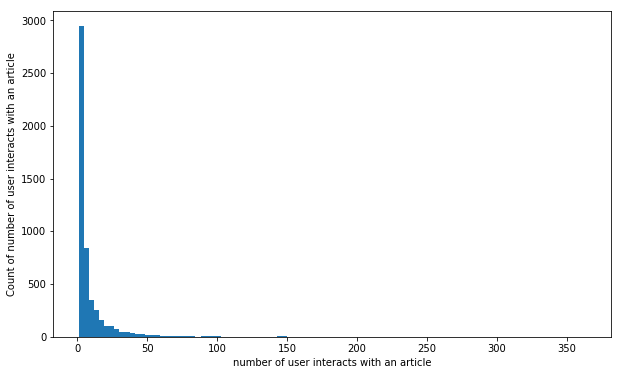

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(email_group, bins=100)
plt.xlabel("number of user interacts with an article")
plt.ylabel("Count of number of user interacts with an article")
plt.show()

In [7]:
email_group.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

In [8]:
# Fill in the median and maximum number of user_article interactios below

median_val =3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [9]:
# Find and explore duplicate articles
df_content[df_content.duplicated("article_id", keep='first')]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [10]:
# Show one example of the duplicate id
df_content[df_content.article_id == 50]

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50


In [11]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset=['article_id'], inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [12]:
#df.dropna(how='any', inplace=True)
print("a. Interaction article: ", df.article_id.nunique())
print("b. Platform article: ", df_content.article_id.nunique())
print("c. Unique users", df.dropna(how='any').email.nunique())
print("d. total user-article", df.shape[0])

a. Interaction article:  714
b. Platform article:  1051
c. Unique users 5148
d. total user-article 45993


In [13]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [14]:
# use value_counts or groupby
df.groupby('article_id').count().sort_values(by='email', ascending=False).head()

,title,email
article_id,,
1429.0,937,937
1330.0,927,927
1431.0,671,671
1427.0,643,643
1364.0,627,627


In [15]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [16]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [17]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


In [18]:
df.article_id.value_counts(sort=True, ascending=False).index[:2].tolist()

['1429.0', '1330.0']

### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [19]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles_ids = get_top_article_ids(n, df)
    top_articles = df[df.article_id.isin(top_articles_ids)]['title'].unique().tolist()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    # Your code here
    top_articles = df.article_id.value_counts(sort=True, ascending=False).index[:n].tolist()
 
    return top_articles # Return the top article ids

In [20]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [21]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [22]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    df = df.drop_duplicates(subset=['article_id', 'user_id'])
    
    user_item = df.groupby(['user_id', 'article_id'])['title'].count().unstack()
    
    # if no interaction, fill na to zero
    user_item.fillna(0, inplace=True)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)
user_item.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [24]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    user_row = user_item.loc[user_id].values
    dot_prod = pd.Series(np.dot(user_row, user_item.T), index=user_item.index)

    # sort by similarity
    dot_prod_sorted = dot_prod.sort_values(ascending=False)
    
    # remove the own user's id
    dot_prod_sorted = dot_prod_sorted[dot_prod_sorted.index != user_id]

    # create list of just the ids
    most_similar_users = dot_prod_sorted.index.tolist()
   
    
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [25]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [26]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    df =  df[df.article_id.isin(article_ids)]
    
    # a few articles have extra information in the end of the title
    df = df.title.str.replace("\nName: title, dtype: object", "")
    article_names = df.unique().tolist()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    # get row of user
    article_ids = user_item.loc[user_id]
    
    # locate items with interactions
    with_interaction = article_ids[article_ids == 1]
    
    article_ids = with_interaction.index.tolist()
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    # recommend article ids
    recs = []
    # get articles seen by current user
    article_seen_ids, article_seen = get_user_articles(user_id)
    # find similar users of the current user
    similar_users = find_similar_users(user_id)
    
    for user in similar_users:
        # Find article ids which have been seen
        possible_artcile_ids, possible_artciles = get_user_articles(user)
        new_article_ids = np.setdiff1d(possible_artcile_ids, article_seen_ids)
        # Add to recommendation list
        recs.extend(new_article_ids)
        if len(recs) >= m:
            break
    # it is possible that the total length of recs is more than m
    recs = recs[:m]
    return recs # return your recommendations for this user_id    

In [27]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['analyze energy consumption in buildings',
 'analyze accident reports on amazon emr spark',
 '520    using notebooks with pixiedust for fast, flexi...',
 '1448    i ranked every intro to data science course on...',
 'data tidying in data science experience',
 'airbnb data for analytics: vancouver listings',
 'recommender systems: approaches & algorithms',
 'airbnb data for analytics: mallorca reviews',
 'analyze facebook data using ibm watson and watson studio',
 'a tensorflow regression model to predict house values']

In [28]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [29]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    # Select user row
    user_row = user_item.loc[user_id].values
    # calculate dot_prod with all users, and convert it to dataframe
    # The index defaults to be all user ids
    dot_prod = pd.Series(np.dot(user_row, user_item.T), index=user_item.index)
    neighbors_df = pd.DataFrame({'similarity': dot_prod})
    
    # Get user article dataframe
    user_article_df = pd.DataFrame(df.groupby(['user_id'])['article_id'].count())
    
    # concate the dataframe based on user_id index
    neighbors_df = pd.concat([neighbors_df, user_article_df], axis=1).reset_index()
    
    # rename the column names, remove user itself, and sort by similarity and num_interactions
    neighbors_df.rename(columns={'user_id': 'neighbor_id', 'article_id': 'num_interactions'}, inplace=True)
    neighbors_df = neighbors_df[neighbors_df.neighbor_id != user_id]
    neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=[False, False], inplace=True)

    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    # store recommended article ids
    recs = []
    
    #get top sorted users
    top_users_df = get_top_sorted_users(user_id)
    neighbors = top_users_df.neighbor_id.values
    
    # Rank articles according to number of interactions
    article_interaction = df.groupby(['article_id'])['user_id'].count()
    # get articles seen by current users
    seen_article_ids, seen_articles = get_user_articles(user_id=user_id)
    for neighbor in neighbors:
        # get articles from similar user
        possible_article_ids, possible_articles = get_user_articles(neighbor)
        
        # new articles to be recommended
        new_articles = np.setdiff1d(possible_article_ids, seen_article_ids)
        
        # sort recommended articles by interactions
        sorted_new_articles = article_interaction.loc[new_articles].sort_values(ascending=False).index.tolist()
        
        # extend recommended articles list
        recs.extend(sorted_new_articles)
        
        if len(recs) >= m:
            break
            
    recs = recs[:m]
    rec_names = get_article_names(recs)
    
    
    return recs, rec_names

In [30]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1427.0', '1364.0', '1170.0', '1162.0', '1304.0', '1351.0', '1160.0', '1354.0', '1368.0']

The top 10 recommendations for user 20 are the following article names:
['apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'putting a human face on machine learning', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [31]:
get_top_sorted_users(1).head()

,neighbor_id,similarity,num_interactions
3932,3933,35.0,45
22,23,17.0,364
3781,3782,17.0,363
202,203,15.0,160
4458,4459,15.0,158


In [32]:
get_top_sorted_users(131).head(10)

,neighbor_id,similarity,num_interactions
3869,3870,74.0,144
3781,3782,39.0,363
22,23,38.0,364
202,203,33.0,160
4458,4459,33.0,158
97,98,29.0,170
3763,3764,29.0,169
48,49,29.0,147
3696,3697,29.0,145
241,242,25.0,148


In [35]:
### Tests with a dictionary of results

user1_most_sim = int(get_top_sorted_users(1).iloc[0]['neighbor_id']) # Find the user that is most similar to user 1 
user131_10th_sim = int(get_top_sorted_users(131).iloc[9]['neighbor_id']) # Find the 10th most similar user to user 131

In [36]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

A new user has no interactions with any articles. We can recommend him the most popular articles, which can be achieved through get_top_articles and get_top_article_ids. There are some other ways for new user recommendation. 1) We could collect the users' interest when they registered the website, and recommend them the corresponding articles based on their preference; 2) some users might register the website through facebook/twitter and other social networks. If we can find their friend in our platform, we could recommend the new users related articles which were seen by their friends.   

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [37]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)# Your recommendations here



In [38]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [39]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

In [40]:
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [41]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [42]:
# Check null value
df_content.isnull().mean()

doc_body           0.013321
doc_description    0.002854
doc_full_name      0.000000
doc_status         0.000000
article_id         0.000000
dtype: float64

In [43]:
def tokenize(text):
    """
    Clean and tokenize text for NLP. 
    text: string, the message to be clean and tokenized
    return: clean_tokens - the list containing the cleaned and tokenized words of the message
    """
    
    # Normalize and remove punctuations
    text = re.sub(r"[^a-zA-Z0-9]", ' ', text.lower())
    
    # Tokenize
    words = word_tokenize(text)
    
    # Remove Stopwords
    words = [w for w in words if w not in stopwords.words('english')]
    
    # Lemmatize all the nouns and verbs
    lemmatizer = WordNetLemmatizer()
    clean = [lemmatizer.lemmatize(w, pos='n').strip() for w in words]
    clean = [lemmatizer.lemmatize(w, pos='v').strip() for w in clean]
    
    return clean

def vectorize(df_content, col='doc_full_name'):
    """
    TfidfVectorize the column of df_content, and put them back as new columns
    df_content: content df
    column: doc_full_name, doc_description, or doc_body
    return: expanded dataframe with the extra columns
    """
    
    tf = TfidfVectorizer(tokenizer=tokenize, min_df=0.001, max_df=0.999)
    tf_fit = tf.fit_transform(df_content[col])
    tf_df = pd.DataFrame(tf_fit.toarray(), columns=tf.get_feature_names())
    
    df_concat = pd.concat([df_content, tf_df], axis=1)
    
    return df_concat

In [44]:
# For simiplicity, drop all nan (~1.3%)
df_content_new = df_content.dropna().reset_index(drop=True)

df_content_new = vectorize(df_content_new, 'doc_description')
df_content_new = df_content_new.iloc[:, 4:]

In [45]:
def reduce_dimensionality(df_content, n_features):
    """
    df_content: Tfidf vector representations
    n_features: PCA features
    return: new df with reduced PCA components
    """
    pca = PCA(n_components=n_features)
    # assuming incoming df_content with first column article_id, and the rest from Tfidf vectorization
    pca_fit = pca.fit_transform(df_content.iloc[:, 1:])
    pca_df = pd.DataFrame(pca_fit, columns=[i for i in range(n_features)], index=df_content.article_id)
    
    return pca_df

In [46]:
df_pca = reduce_dimensionality(df_content_new, 90)

In [47]:
def compute_similarity(article_id, df_pca):
    """
    article_id: id of input articles
    df_pca: df_content after PCA
    return: neighbor_df with article ids ranked by the norm distance
    """
    # Row of interest
    article_row = df_pca.loc[article_id, :]
    
    # calculate the norm of row with all other rows
    distance = np.sqrt(((df_pca - article_row) ** 2).sum(axis=1))
    
    # Feed to neighbors df, remove the article itself, and sort by similarity
    neighbors_df = pd.DataFrame({'similarity': distance})
    neighbors_df.drop(article_id, inplace=True)
    neighbors_df.sort_values(by='similarity', inplace=True)
    
    return neighbors_df

In [48]:
def article_id_to_info(article_ids, df_content=df_content, col='doc_full_name'):
    """
    Given article_id, return the cell of interest
    df_content: contains doc_body, doc_description, doc_full_name, and article_id, etc
    article_id: article id of interest
    col: column of interest
    """
    return df_content[df_content.article_id.isin(article_ids)][col].tolist()

In [49]:
# Check a few examples
article_id = 0
print("Original title: ", article_id_to_info(article_ids=[article_id]))
neighbors_df = compute_similarity(article_id, df_pca)
print("Similar title: ", article_id_to_info(article_ids=neighbors_df.index[:4]))
print(neighbors_df.index[:4])
print()
article_id = 3
print("Original title: ", article_id_to_info(article_ids=[article_id]))
neighbors_df = compute_similarity(article_id, df_pca)
print("Similar title: ", article_id_to_info(article_ids=neighbors_df.index[:4]))
print(neighbors_df.index[:4])

Original title:  ['Detect Malfunctioning IoT Sensors with Streaming Analytics']
Similar title:  ['Introducing Streams Designer', 'Data science for real-time streaming analytics', 'The Art of Side Effects: Curing Apache Spark Streaming’s Amnesia (Part 1/2)', 'Real-time Sentiment Analysis of Twitter Hashtags with Spark']
Int64Index([1005, 194, 515, 53], dtype='int64', name='article_id')

Original title:  ['DataLayer Conference: Boost the performance of your distributed database']
Similar title:  ['Graph-based machine learning', 'DataLayer Conference: Translating Backend Data to Frontend Needs', 'Missing data conundrum: Exploration and Imputation Techniques', 'On calculating AUC']
Int64Index([50, 129, 701, 794], dtype='int64', name='article_id')


In [50]:
def make_content_recs(article_id, df_pca, m=10):
    '''
    INPUT:
    article_id: article_id of interest
    df_pca: vectorized df_content with PCA results
    m: number of recommendations
    
    OUTPUT: recommended article ids and names
    
    '''
    neighbors_df = compute_similarity(article_id, df_pca)
    rec_article_ids = neighbors_df.index[:m].tolist()
    rec_article_names = article_id_to_info(article_ids=rec_article_ids, col="doc_full_name")
    
    return rec_article_ids, rec_article_names

In [51]:
make_content_recs(0, df_pca, 10)

([1005, 194, 515, 53, 681, 1031, 68, 862, 670, 782],
 ['Introducing Streams Designer',
  'An Introduction to Scientific Python (and a Bit of the Maths Behind It) – NumPy',
  'Data science for real-time streaming analytics',
  'The Art of Side Effects: Curing Apache Spark Streaming’s Amnesia (Part 1/2)',
  'Calculate moving averages on real time data with Streams Designer',
  'Real-Time Sentiment Analysis of Twitter Hashtags with Spark (+ PixieDust)',
  'Effectively Using\xa0Matplotlib',
  'Time Series Analysis Using Max/Min and Neuroscience',
  'Real-time Sentiment Analysis of Twitter Hashtags with Spark',
  'The Definitive Guide'])

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

The content based recommendation system is to recommend similar articles based on the Euclidean distance between the doc description of these articles. If the two articles have close doc descritions, the Euclidean distance will be close to zero. One could also use the doc_body information to calculate the Eculidean distance which might provide better match of the recommender system.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [52]:
# make recommendations for a brand new user
# we simply recommend most popular articles for a brand new user
print(get_top_article_ids(10))
print(get_top_articles(10))


['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']
['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']


In [53]:
### make a recommendations for a user who only has interacted with article id '1427.0'

item_title = df[df.article_id == '1427.0']['title'].iloc[0]
print("1427 title:", item_title)

# Since 1427 does not exist in df_content, we rebuild the df with an extra row
# the title was put in to body, description, and full name area
df_content_new_item = pd.DataFrame({'doc_body': item_title, 'doc_description': item_title, 'doc_full_name':item_title,
                                   'doc_status': 'Live', 'article_id': 1427}, index=[1427])

# Redo the vectorization and PCA
df_content = df_content.append(df_content_new_item)
df_content_new = df_content.dropna().reset_index(drop=True)

df_content_new = vectorize(df_content_new, 'doc_description')
df_content_new = df_content_new.iloc[:, 4:]
df_pca = reduce_dimensionality(df_content_new, 90)

# make recommendations
make_content_recs(1427, df_pca, 10)

1427 title: use xgboost, scikit-learn & ibm watson machine learning apis


([667, 805, 723, 15, 762, 107, 884, 254, 632, 967],
 ['Apache Spark™ 2.0: Extend Structured Streaming for Spark ML',
  'When machine learning matters · Erik Bernhardsson',
  'Apple, IBM add machine learning to partnership with Watson-Core ML coupling',
  'Hyperparameter Optimization: Sven Hafeneger',
  'Imitation Learning in Tensorflow (Hopper from openAI gym)',
  '10 Essential Algorithms For Machine Learning Engineers',
  'From Machine Learning to Learning Machine (Dinesh Nirmal)',
  'Machine Learning for everyone',
  'Don’t overlook simpler techniques and algorithms',
  'ML Algorithm != Learning Machine'])

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [54]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [55]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [58]:
# Check NAN values in the user_item_matrix
user_item_matrix.isnull().sum().sum()

0

In [54]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=False) # use the built in to get the three matrices

In [55]:
print("u shape {}, s shape {}, vt shape {}".format(u.shape, s.shape, vt.shape))

u shape (5149, 714), s shape (714,), vt shape (714, 714)


**Provide your response here.**

The user_item_matrix does not contain NAN values, therefore, we could perform SVD on the matrix directly with np.linalg.svd. If there are nan values in the matrix, we must use FunkSVD, as shown in the lesson.

The user_item interaction definition is playing an important role here. For the movie recommendation in the lesson, if a user hasn't seen the movie, the label will be nan since no rating is given. However, if a user hasn't seen the article in our case, the label will 0. There is should be no nan label in our user_item_matrix.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

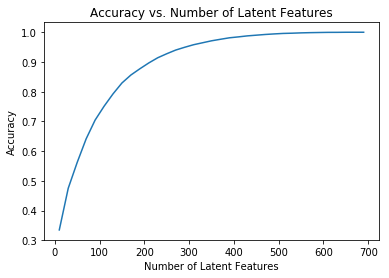

In [56]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [57]:
create_user_item_matrix(df).head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index.values
    test_arts = user_item_test.columns.values
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [59]:
print("Total users in traing dataset:", user_item_train.index.values.shape[0])
print("Total users in test dataset:", test_idx.shape[0])

common_users = np.intersect1d(test_idx, user_item_train.index.values)
print("Total users in both training and test", len(common_users))
print("Cold start users in test", test_idx.shape[0] - len(common_users))

Total users in traing dataset: 4487
Total users in test dataset: 682
Total users in both training and test 20
Cold start users in test 662


In [60]:
print("Total articles in traing dataset:", user_item_train.columns.values.shape[0])
print("Total articles in test dataset:", test_arts.shape[0])

common_arts = np.intersect1d(test_arts, user_item_train.columns.values)
print("Total articles in both training and test", len(common_arts))
print("Cold start articles in test", test_arts.shape[0] - len(common_arts))

Total articles in traing dataset: 714
Total articles in test dataset: 574
Total articles in both training and test 574
Cold start articles in test 0


In [61]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [62]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=False) # fit svd similar to above then use the cells below
u_train.shape, s_train.shape, vt_train.shape

((4487, 714), (714,), (714, 714))

In [63]:
# Since only 20 users in test data were shown in training data, we will have a cold-start problem for the remaining 574 users.
# Take the 20 users for prediction validation
u_test = u_train[user_item_train.index.isin(test_idx)]
u_test.shape

(20, 714)

In [64]:
# 574 articles from test dataset
vt_test = vt_train[:, user_item_train.columns.isin(test_arts)]
vt_test.shape

(714, 574)

In [65]:
# We only need a subset of the user_item_train with matrix shape u_tst x vt_test
common_users = np.intersect1d(test_idx, user_item_train.index.values)
user_item_test_subset = user_item_test[user_item_test.index.isin(common_users)]
user_item_test_subset.shape

(20, 574)

In [66]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

num_latent_feats = np.arange(10, 700 + 10, 20)
train_accuracy_list = []
test_accuracy_list = []
train_f1_list = []
test_f1_list = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    
    user_item_train_pred = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_test_pred = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    # Confine values to 0 and 1
    user_item_train_pred = np.clip(user_item_train_pred, 0, 1)
    user_item_test_pred = np.clip(user_item_test_pred, 0, 1)
    
    # get accuracy and f1 score
    train_accuracy = accuracy_score(np.array(user_item_train).flatten(), user_item_train_pred.flatten())
    test_accuracy = accuracy_score(np.array(user_item_test_subset).flatten(), user_item_test_pred.flatten())
    
    train_f1 = f1_score(np.array(user_item_train).flatten(), user_item_train_pred.flatten())
    test_f1 = f1_score(np.array(user_item_test_subset).flatten(), user_item_test_pred.flatten())
    
    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)
    train_f1_list.append(train_f1)
    test_f1_list.append(test_f1)
    

In [67]:
def view_score(train, train_label, test, test_label, 
               x=num_latent_feats, x_label='Number of Latent Features'):
    """
    Visualization function to compare training and testing scores
    x, x_label: the number of latent Features list
    train, train_label: training accuracy or f1 list
    test, test_score: testing accuracy or f1 list
    """
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(train_label, color=color)
    ax1.plot(x, train, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel(test_label, color=color)  # we already handled the x-label with ax1
    ax2.plot(x, test, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

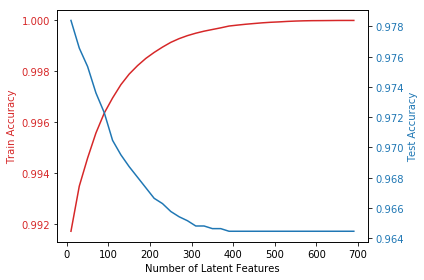

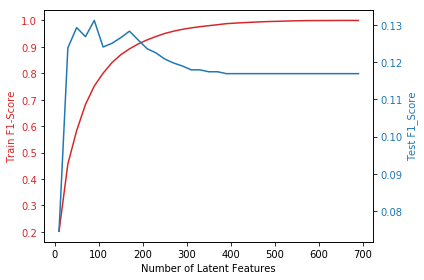

In [68]:
view_score(train_accuracy_list, "Train Accuracy", test_accuracy_list, "Test Accuracy")
view_score(train_f1_list, "Train F1-Score", test_f1_list, "Test F1_Score")

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

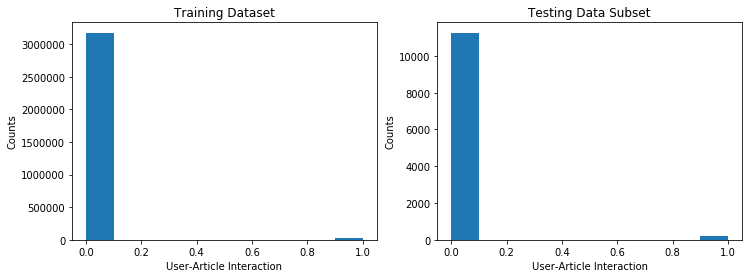

In [69]:
# Check the user_article distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(np.array(user_item_train).flatten())
plt.xlabel("User-Article Interaction")
plt.ylabel("Counts")
plt.title("Training Dataset")
plt.subplot(1, 2, 2)
plt.hist(np.array(user_item_test_subset).flatten())
plt.xlabel("User-Article Interaction")
plt.ylabel("Counts")
plt.title("Testing Data Subset")
plt.show()

**Your response here.**

It is important to notice that, in both training dataset and the testing dataset, the binary classes are extremely imbalanced. Most articles have not been read by any users and the majority labels of the user-item matrix are filled with 0 as compared to 1. A blind machine learning model which classifies all labels as 0 will reach a good accuracy score, since it will be accurate for majority of the cases (0). Therefore, it is not good to use accuracy score to determine the goodness of fitting. The F1-score is a better metric to determine the goodness of fitting. To fight the overfitting, the number of features should be reduced.  As shown from the test F1_score curve, the highest F1-score ~0.13 is obtained with ~90 latent features.

The cold start problem is another challenge for our the FunkSVD recommendation method. Of the 682 users in the test dataset, only 20 users showed up in the training dataset and the rest 662 users cannot be predicted. We should seek to obtain more data to solve the problem.

The lack of article rating metric limits the performance of our models. The current metric is based on the user-article interactions, which does not account for the preference of the user to the article. A user might have read the article and does not like it, but the current metric will label it as preference (1). If it is hard to collect complex ratings from the users, the simple like/dislike vote button could help to improve the recommendation systems.

If the platform is online, we could test the recommendation performance through A/B test. We could assign half of our users into a control group and the other half users into experimental group. The control group will use the old recommendation system whereas the experimental group will use the new experimental groups. We could use the average article interactions per user as a metric to determine if the new recommendation system is better or not than the old system.


<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [70]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0